## Kue Dataset - Model2

overfit model2


In [1]:
# conda install -c conda-forge keras

In [2]:
import os
import re
import glob

import scipy.io
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io import loadmat
import random
import sklearn
import seaborn as sns

In [3]:
# PATH_DATA = '../data/'
PATH_DATA_IMAGES = '../../../../My_Dataset/images/dataset257/'
PATH_DATA_TRAIN = PATH_DATA_IMAGES+'train/'
PATH_DATA_VAL = PATH_DATA_IMAGES+'validation/'
PATH_DATA_TEST = PATH_DATA_IMAGES+'test/'
PATH_MODEL = '../../tmp/'

In [4]:
os.listdir(PATH_DATA_TRAIN)

['.DS_Store',
 'kue_dadar_gulung',
 'kue_kastengel',
 'kue_klepon',
 'kue_lapis',
 'kue_lumpur',
 'kue_putri_salju',
 'kue_risoles',
 'kue_serabi']

## Modeling

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model


Using TensorFlow backend.


In [6]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
## label dict
lab = [i for i in os.listdir(PATH_DATA_TRAIN) if '.' not in i]
lab.sort()

label_dict = dict(zip(lab,[i for i in range(len(lab))]))
label_dict

{'kue_dadar_gulung': 0,
 'kue_kastengel': 1,
 'kue_klepon': 2,
 'kue_lapis': 3,
 'kue_lumpur': 4,
 'kue_putri_salju': 5,
 'kue_risoles': 6,
 'kue_serabi': 7}

In [9]:
LABEL_SIZE = len(label_dict.keys())
IMAGE_SIZE = 128

In [10]:
just_cake_model = Sequential()
just_cake_model.add(Conv2D(64, (3, 3), activation ='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
just_cake_model.add(Conv2D(32, (3, 3), activation ='relu'))
just_cake_model.add(Conv2D(16, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Conv2D(16, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))

just_cake_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
just_cake_model.add(Dense(512, activation ='relu'))
just_cake_model.add(Dense(256, activation ='relu'))
just_cake_model.add(Dense(128, activation ='relu'))
just_cake_model.add(Dense(32, activation ='relu'))
just_cake_model.add(Dense(LABEL_SIZE,activation ='softmax'))

In [11]:
just_cake_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 16)      4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13456)            

In [12]:
## compile model
opt = optimizers.Adam(learning_rate=0.01)
just_cake_model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer = opt,
              metrics=['accuracy',metrics.AUC()])

In [13]:
## data generator
BATCH_SIZE = 64
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=35,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.25,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        PATH_DATA_TRAIN,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

val_generator = val_datagen.flow_from_directory(
        PATH_DATA_VAL,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

test_generator = test_datagen.flow_from_directory(
        PATH_DATA_TEST,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical" )

Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [14]:
## save best model and use early stopping
early_stop = keras.callbacks.EarlyStopping(
        monitor='loss',mode='min', patience=8) 
check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'just_cake_model_checkpoint2-overfit2.h5',
        monitor='loss',
        mode='min',
        save_best_only=True)

epoch_hist = just_cake_model.fit(
        train_generator,
        steps_per_epoch=1516 // BATCH_SIZE,
#         validation_data=val_generator,
#         validation_steps=160 // BATCH_SIZE,
        callbacks=[early_stop,check_p],
        epochs=250)

Epoch 1/250
18/23 [======================>.......] - ETA: 16s - loss: 2.2552 - accuracy: 0.1246 - auc_1: 0.4935

ResourceExhaustedError:  OOM when allocating tensor with shape[64,64,126,126] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients/conv2d_2/convolution_grad/Conv2DBackpropInput (defined at c:\users\aska\anaconda3\envs\onoenv\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_2415]

Function call stack:
keras_scratch_graph


## Evaluations

In [25]:
df_epoch_hist = pd.DataFrame(epoch_hist.history)

<AxesSubplot:>

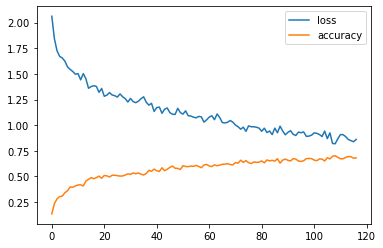

In [26]:
df_epoch_hist[['loss','accuracy']].plot()

In [17]:
df_epoch_hist.to_csv('../artifact/epoch_hist_2-overfit2.csv')

In [18]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'just_cake_model_checkpoint2-overfit2.h5',compile=False)

In [19]:
true_labels = val_generator.classes
predictions = model_load.predict(val_generator)

y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

<AxesSubplot:>

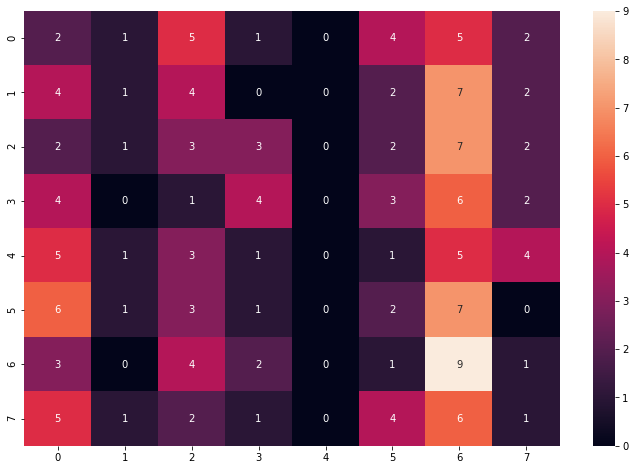

In [20]:
plt.figure(figsize = (12,8))
sns.heatmap(cm, annot= True)

In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.10      0.08        20
           1       0.17      0.05      0.08        20
           2       0.12      0.15      0.13        20
           3       0.31      0.20      0.24        20
           4       0.00      0.00      0.00        20
           5       0.11      0.10      0.10        20
           6       0.17      0.45      0.25        20
           7       0.07      0.05      0.06        20

    accuracy                           0.14       160
   macro avg       0.13      0.14      0.12       160
weighted avg       0.13      0.14      0.12       160



c:\users\aska\anaconda3\envs\onoenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
